# Integration of BAL samples (v9)

Here we:
- Record study statuses
- Clean up the DC2 cluster, removing a cluster of FABP4 TRAM doublets
- Merge two CD8 T cell clusters that lack distinct marker genes
- Clean up cell type names
- Simplify HV study IDs

In [1]:
import scanpy as sc
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
in_version = "v8"
in_dir = f"01BAL/01integrated_BAL_{in_version}"
in_name = f"01integrated_BAL_{in_version}"

adata = sc.read_h5ad(f"{data_dir}/{in_dir}/{in_name}.h5ad")
adata.obs["cluster"] = adata.obs.subcluster

In [4]:
adata.obs["is_PASC"] = adata.obs["is_PASC"].cat.rename_categories({"False" : "Control", "True" : "PASC"})
status = np.array(adata.obs["is_PASC"].cat.rename_categories({"False" : "Control", "True" : "PASC"}))

transplant_subject = ["RPRA12", "RPRA13"]
status[[x in transplant_subject for x in adata.obs.Study_ID]] = "PASC (transplant)"

adata.obs["Status"] = status

## Resolve DC2 cluster

In [5]:
ix = adata[adata.obs.cell_type == "DC2"].obs.subcluster[0]
adata_sub = adata[adata.obs.subcluster == ix].copy()

In [6]:
sc.tl.leiden(adata_sub, key_added = 'cluster', resolution = 0.1)
cats = adata_sub.obs['cluster'].cat
adata_sub.obs['cluster'] = cats.rename_categories({c: str(ix) + '-' + c for c in cats.categories})

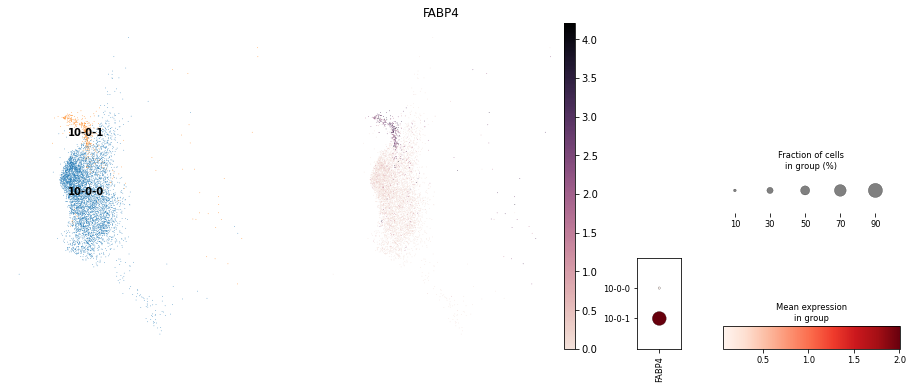

In [8]:
mpl.rcParams["figure.figsize"] = (16, 6)
fig, ax = plt.subplots(1, 3)
sc.pl.umap(adata_sub, color = "cluster", legend_loc = "on data", frameon = False, title = "",
           size = 2, show = False, ax = ax[0])
sc.pl.umap(adata_sub, color = "FABP4", legend_loc = "on data", frameon = False, title = "FABP4",
           size = 2, show = False, ax = ax[1],
           cmap = sns.cubehelix_palette(dark = 0, light = 0.9, as_cmap = True))
sc.pl.dotplot(adata_sub, "FABP4", groupby = "cluster", show = False, ax = ax[2]);

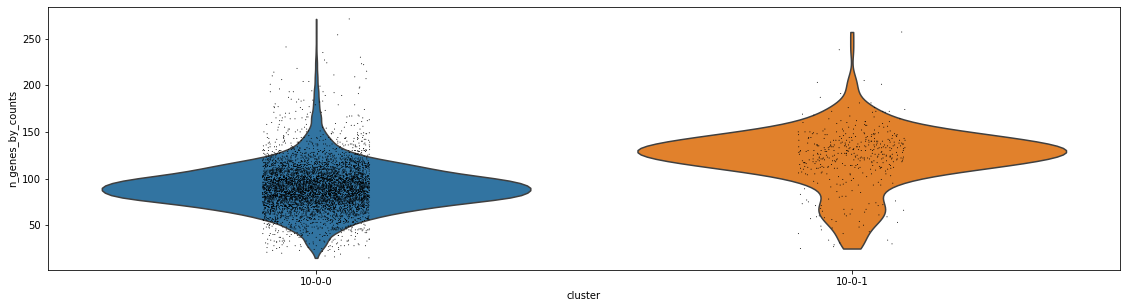

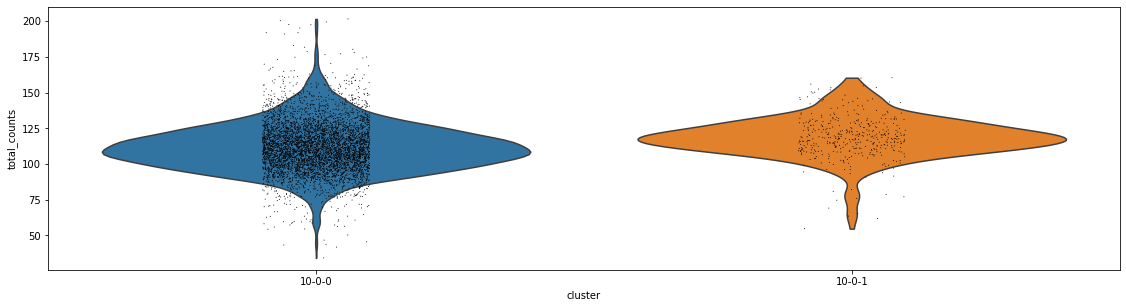

In [9]:
sc.pp.calculate_qc_metrics(adata_sub, percent_top = None, log1p = False, inplace = True)
mpl.rcParams["figure.figsize"] = (15, 5)
sc.pl.violin(adata_sub, "n_genes_by_counts", groupby = "cluster")
sc.pl.violin(adata_sub, "total_counts", groupby = "cluster")

Cluster 10-0-1 looks to the cluster of FABP4 TRAM doublets. We will remove it.

In [10]:
doublets = adata_sub[adata_sub.obs.cluster == "10-0-1"].obs.index
adata = adata[~adata.obs.index.isin(doublets)].copy()

## Rename cell types
Note we also merge CD8 T cells-1 and CD8 T cells-3.

In [11]:
new_cell_names = {
    'Classical monocytes': 'Classical monocytes',
    'Non-classical monocytes': 'Non-classical monocytes',
    'MoAMs - 2': 'MoAM-1',
    'MoAMs - 0': 'MoAM-2',
    'MoAMs - 3': 'MoAM-3',
    'MoAMs - 4': 'MoAM-4',
    'MoAMs - 5': 'MoAM-5',
    'MoAMs - 1': 'MoAM-6',
    'TRAM1': 'TRAM-1',
    'TRAM2': 'TRAM-2',
    'TRAM3': 'TRAM-3',
    'TRAM4 (SOD2, CCL3, CCL4)': 'TRAM-4',
    'TRAM5 (MT1G)': 'TRAM-5',
    'Perivascular macrophages': 'Perivascular macrophages',
    'Proliferating TRAM': 'Proliferating macrophages',
    'DC1': 'DC1',
    'DC2': 'DC2',
    'CCR7 migratory DC': 'CCR7 migratory DC',
    'pDC': 'pDCs',
    'B cells': 'B cells',
    'Plasma cells': 'Plasma cells',
    'CD4 T cells - 0': 'CD4 T cells-1',
    'CD4 T cells - 1': 'CD4 T cells-2',
    'CD4 T cells - 2': 'CD4 T cells-3',
    'CD4 T cells - 3': 'CD4 T cells-4',
    'Tregs (FOXP3)': 'Tregs',
    'CD8 T cells - 0': 'CD8 T cells-1',
    'CD8 T cells - 1': 'CD8 T cells-2',
    'CD8 T cells - 2': 'CD8 T cells-3',
    'CD8 T cells - 3': 'CD8 T cells-2',
    'Proliferating T cells': 'Proliferating T cells',
    'NK and gdT cells': 'NK and gdT cells',
    'Mast cells': 'Mast cells',
    'Epithelial cells': 'Epithelial cells',
    'SARS-CoV-2': 'SARS-CoV-2'
}
adata.obs.cell_type = adata.obs.cell_type.map(new_cell_names).astype('category')
np.unique([x for x in adata.obs.cell_type])

array(['B cells', 'CCR7 migratory DC', 'CD4 T cells-1', 'CD4 T cells-2',
       'CD4 T cells-3', 'CD4 T cells-4', 'CD8 T cells-1', 'CD8 T cells-2',
       'CD8 T cells-3', 'Classical monocytes', 'DC1', 'DC2',
       'Epithelial cells', 'Mast cells', 'MoAM-1', 'MoAM-2', 'MoAM-3',
       'MoAM-4', 'MoAM-5', 'MoAM-6', 'NK and gdT cells',
       'Non-classical monocytes', 'Perivascular macrophages',
       'Plasma cells', 'Proliferating T cells',
       'Proliferating macrophages', 'SARS-CoV-2', 'TRAM-1', 'TRAM-2',
       'TRAM-3', 'TRAM-4', 'TRAM-5', 'Tregs', 'pDCs'], dtype='<U25')

## Recode HV IDs

In [ ]:
metadata = pd.read_csv(f"{data_dir}/clinical/metadata.csv")
def new_id(x):
    return metadata.loc[metadata["Old ID"] == x, "Study ID"].values[0] if x[0:4] != "PASC" else x
new_ids = {x: new_id(x) for x in np.unique(adata.obs.Study_ID)}
adata.obs.Study_ID = adata.obs.Study_ID.cat.rename_categories(new_ids)
np.unique([x for x in adata.obs.Study_ID])

## Clean up cluster metadata

In [ ]:
adata.obs = adata.obs.drop(columns = ["subcluster", "leiden_scVI"])
old_clusters = np.unique(adata.obs.cluster)
new_clusters = {old_clusters[i]: i for i in range(len(old_clusters))}
adata.obs.cluster = adata.obs.cluster.cat.rename_categories(new_clusters)
adata.obs

## Recompute markers

In [14]:
adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata, "cell_type", method = "wilcoxon", n_genes = 200)

/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

In [15]:
markers = sc_utils.get_markers(adata, "cell_type")
pd.options.display.max_rows = 500
markers.groupby("cluster").apply(lambda x: x.sort_values("avg_logFC", ascending = False).head(10))

p_val  avg_logFC     pct.1     pct.2  \
cluster                                                                        
B cells                   0      0.000000e+00  12.359785  0.924928  0.001219   
                          1      0.000000e+00  10.107925  0.819484  0.002895   
                          190    4.465347e-40   9.835588  0.187393  0.000453   
                          17    3.598433e-270   9.590095  0.491117  0.003183   
                          44    2.575097e-200   9.567986  0.422350  0.001705   
                          98     4.963950e-97   9.297208  0.293410  0.001008   
                          156    7.042376e-55   9.224738  0.220057  0.000769   
                          49    3.757972e-191   8.988769  0.412607  0.001425   
                          106    5.132728e-93   8.454641  0.287679  0.001413   
                          144    6.778897e-64   8.430261  0.237822  0.000883   
CCR7 migratory DC         328   8.795935e-131  10.735249  0.445866  0.000803   
                          229   8.854327e-297  10.628035  0.672244  0.001074   
                          202    0.000000e+00   9.861738  0.901575  0.010085   
                          220    0.000000e+00   9.069840  0.724409  0.008014   
                          200    0.000000e+00   9.056147  0.918307  0.010226   
                          322   3.718101e-136   8.919339  0.455709  0.001659   
                          381    9.844109e-94   8.881636  0.377953  0.001631   
                          287   6.219974e-177   7.602535  0.521654  0.003464   
                          203    0.000000e+00   7.538202  0.893701  0.018498   
                          319   2.961138e-137   7.403924  0.461614  0.007117   
CD4 T cells-1             451    0.000000e+00   4.959848  0.423458  0.021688   
                          400    0.000000e+00   3.844614  0.950634  0.269040   
                          508    0.000000e+00   3.796538  0.309492  0.029235   
                          499    0.000000e+00   3.158393  0.358236  0.056617   
                          431    0.000000e+00   3.153577  0.547809  0.100225   
                          401    0.000000e+00   3.135136  0.833760  0.232599   
                          597   4.067883e-238   3.056204  0.190750  0.027899   
                          567    0.000000e+00   2.983784  0.234093  0.036159   
                          402    0.000000e+00   2.979882  0.840199  0.217916   
                          563    0.000000e+00   2.965919  0.244686  0.037960   
CD4 T cells-2             768   1.047582e-306   4.235981  0.223618  0.015896   
                          777   5.712748e-262   4.102264  0.206900  0.014553   
                          794   5.520924e-219   3.918203  0.192127  0.016726   
                          604    0.000000e+00   3.666666  0.775144  0.243994   
                          738    0.000000e+00   3.193184  0.275807  0.035921   
                          735    0.000000e+00   3.128065  0.282088  0.038911   
                          610    0.000000e+00   2.996384  0.889960  0.280938   
                          663    0.000000e+00   2.992779  0.511720  0.131598   
                          763    0.000000e+00   2.897550  0.249359  0.035289   
                          652    0.000000e+00   2.891256  0.547015  0.108112   
CD4 T cells-3             872    2.683565e-30   3.960697  0.112896  0.013814   
                          966    2.314600e-08   3.960245  0.056558  0.006508   
                          995    1.138077e-05   3.624705  0.050176  0.010349   
                          986    2.346228e-06   3.148164  0.052377  0.009669   
                          948    4.810983e-10   3.121788  0.068222  0.013105   
                          861    9.950258e-42   3.044701  0.147447  0.032399   
                          900    5.885332e-20   3.016020  0.119498  0.043416   
                          820   2.658971e-196   2.917907  0.348592  0.122786   
                          846    7.58858

## Write output

In [16]:
out_version = "v9"
out_dir = f"01BAL/01integrated_BAL_{out_version}"
out_name = f"01integrated_BAL_{out_version}"

In [17]:
adata.write(f"{data_dir}/{out_dir}/{out_name}.h5ad")
adata.obs.to_csv(f"{data_dir}/{out_dir}/{out_name}-metadata.csv")
markers.to_csv(f"{data_dir}/{out_dir}/{out_name}-markers.csv")